# Time series analysis and forcasting of Harris(Tx) for CO

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from numpy import log
from statsmodels.tsa.stattools import adfuller
import sys
from pandas.plotting import lag_plot
import numpy as np
from pmdarima import auto_arima
import statsmodels.api as sm 
# Adding libraries

In [2]:
x=pd.read_csv("US_CO_2020_final.csv",index_col=0)
z=pd.read_csv("US_CO_2019_final.csv",index_col=0)
ao=pd.concat([z,x])
ao.reset_index(inplace = True, drop = True)
# Getting cleaned dataset of both year(2019 & 2020) from csv file of given pollutant into dataframe and then concatenating them 

In [3]:
am_O3=ao[(ao['state']=='Texas') & (ao['county']=='Harris')]
# Getting dataset of the given county from the whole dataframe for a pollutant

In [4]:
ao3=am_O3.groupby('date_local').mean().drop(columns=['site_number','state_code', 'county_code', 'latitude', 'longitude', 'observation_count', 'first_max_hour', 'arithmetic_mean', 'first_max_value'], axis=1)
# Removing all columns from dataframe except date_local and aqi, to generate the required time series dataframe 

In [5]:
ao3.index=pd.to_datetime(ao3.index)

In [6]:
ao3.describe()

,aqi
count,548.000000
mean,4.437956
std,1.856196
min,1.333333
25%,3.333333
50%,4.000000
75%,4.666667
max,19.000000


In [7]:
ao3

,aqi
date_local,
2019-01-01,19.000000
2019-01-02,2.333333
2019-01-03,2.333333
2019-01-04,7.666667
2019-01-05,13.333333
...,...
2020-06-27,3.666667
2020-06-28,3.000000
2020-06-29,3.000000


## Time series analysis

In [8]:
w=ao3.resample('W').mean()
c=ao3.resample('W').var()

<Figure size 720x720 with 0 Axes>

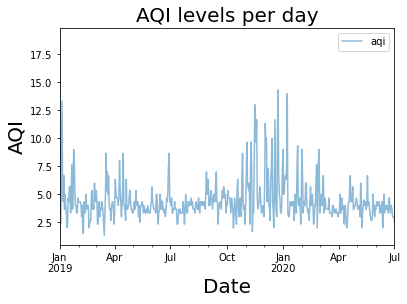

In [9]:
plt.figure(figsize=(10, 10))
ao3.plot(alpha=0.5, style='-')
plt.title('AQI levels per day', fontsize=20)
plt.ylabel('AQI',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.show()

<Figure size 720x720 with 0 Axes>

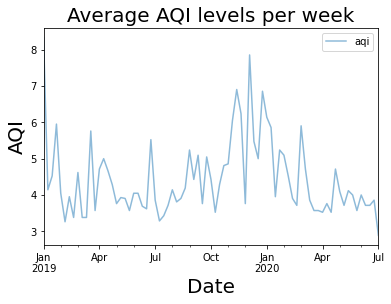

In [10]:
plt.figure(figsize=(10, 10))
w.plot(alpha=0.5, style='-')
plt.title('Average AQI levels per week', fontsize=20)
plt.ylabel('AQI',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.show()

From the plot we can see that the AQI level is decreasing a little from January to June and is then increasing till December.Through this analysis we can deduce that the AQI levels are low in summer and high in winter. Since weekly averaged AQI values are changing a little with time ,therefore we can say that the dataset may not be stationary.As for stationary dataset mean values must be independent of time.

<Figure size 720x720 with 0 Axes>

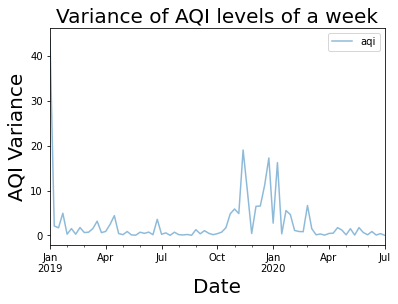

In [11]:
plt.figure(figsize=(10, 10))
c.plot(alpha=0.5, style='-')
plt.title('Variance of AQI levels of a week', fontsize=20)
plt.ylabel('AQI Variance',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.show()
# Plotting weekly averaged dataset

Since varaince is almost constant with time it is a additive seasonality dataset

In [12]:
summary=ao3.groupby(pd.Grouper(freq="M")).agg(
    max_aqi = pd.NamedAgg(column='aqi', aggfunc='max'),
    max_Date = pd.NamedAgg(column='aqi', aggfunc='idxmax'))
# "Summary dataframe" shows maximum aqi value in each month and its corresponding date

In [13]:
summary

,max_aqi,max_Date
date_local,,
2019-01-31,19.000000,2019-01-01
2019-02-28,6.000000,2019-02-27
2019-03-31,8.666667,2019-03-18
2019-04-30,8.666667,2019-04-15
2019-05-31,5.333333,2019-05-06
2019-06-30,8.666667,2019-06-29
2019-07-31,5.000000,2019-07-26
2019-08-31,7.000000,2019-08-29
2019-09-30,7.000000,2019-09-14


In [14]:
summary.shift(1)

,max_aqi,max_Date
date_local,,
2019-01-31,NaN,NaT
2019-02-28,19.000000,2019-01-01
2019-03-31,6.000000,2019-02-27
2019-04-30,8.666667,2019-03-18
2019-05-31,8.666667,2019-04-15
2019-06-30,5.333333,2019-05-06
2019-07-31,8.666667,2019-06-29
2019-08-31,5.000000,2019-07-26
2019-09-30,7.000000,2019-08-29


In [15]:
summary-summary.shift(1)
# It shows that after how much days two consecutive maximun values occur

,max_aqi,max_Date
date_local,,
2019-01-31,NaN,NaT
2019-02-28,-13.000000,57 days
2019-03-31,2.666667,19 days
2019-04-30,0.000000,28 days
2019-05-31,-3.333333,21 days
2019-06-30,3.333333,54 days
2019-07-31,-3.666667,27 days
2019-08-31,2.000000,34 days
2019-09-30,0.000000,16 days


In [16]:
(summary-summary.shift(1)).describe()

,max_aqi,max_Date
count,18.000000,18
mean,-0.907407,30 days 09:20:00
std,3.933775,12 days 15:55:43.623221
min,-13.000000,15 days 00:00:00
25%,-2.333333,20 days 06:00:00
50%,0.000000,27 days 12:00:00
75%,1.583333,37 days 06:00:00
max,4.333333,57 days 00:00:00


Since the data is repeating in 30 days approx. we can take frequency as 1 month.

In [17]:
decomposition = seasonal_decompose(ao3, model='additive', period =30)
trend    = decomposition.trend.fillna(method='bfill')
seasonal = decomposition.seasonal.fillna(method='bfill')
residual = decomposition.resid.fillna(method='bfill')
# Decomposing the dataset into trend,seasonality and residual

In [18]:
trend.head()

date_local
2019-01-01    5.194444
2019-01-02    5.194444
2019-01-03    5.194444
2019-01-04    5.194444
2019-01-05    5.194444
Name: trend, dtype: float64

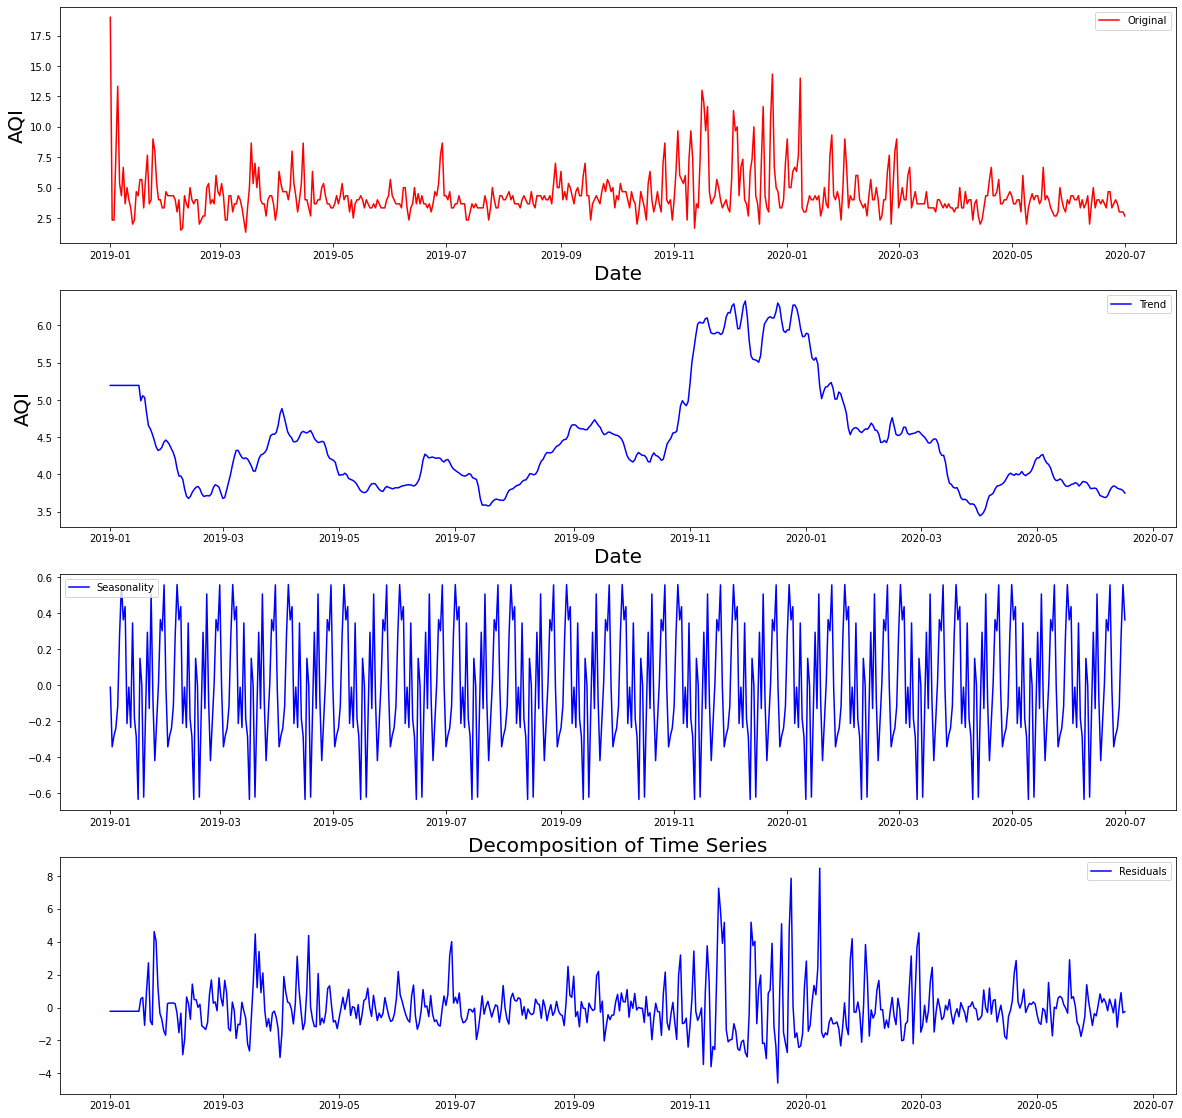

<Figure size 432x288 with 0 Axes>

In [19]:
plt.figure(figsize=(20,20))
plt.subplot(411)
plt.plot(ao3, label='Original', color="red")
plt.legend(loc='best')
plt.ylabel('AQI',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.ylabel('AQI',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.title('Decomposition of Time Series', fontsize=20)
plt.show()

plt.tight_layout()
#Plotting the graphs

We can see from the graphs that the dataset has trend and seasonality,therefore it is not stationary.

In [20]:
X = ao3.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
# Performing the ADFuller test to find whether the timeseries dataset is stationary or not.

ADF Statistic: -2.490299
p-value: 0.117853
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


Since p-value is greater than 0.05 the given time series is not stationary 

## SARIMAX MODEL

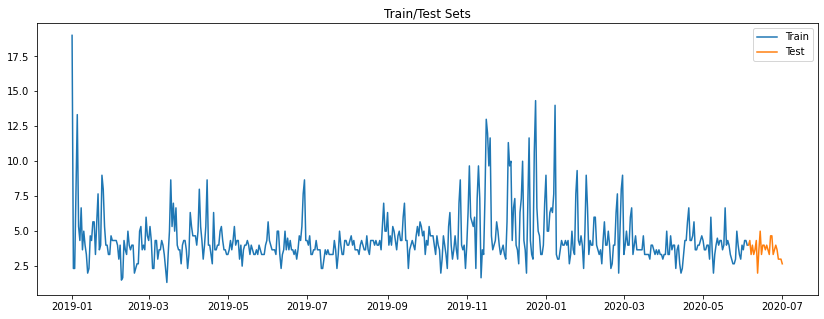

In [21]:
train = ao3[:round(len(ao3) * 0.95)]
test = ao3[round(len(ao3) * 0.95):]
plt.figure(figsize=(14,5))
plt.plot(train.index, train['aqi'], label='Train')
plt.plot(test.index, test['aqi'], color='C1', label='Test')
plt.legend()
plt.title('Train/Test Sets');
# 95% of dataset is trained and 5% of the dataset is tested and is plotted below.

In [22]:
arima = auto_arima(train['aqi'], test = 'adf'
                      , start_p=0, start_q=0, m = 7,
                      stepwise=True, trace = True, 
                      suppress_warnings=True,
                      error_action='ignore', seasonal = True)
# Using Autoarima model, getting suitable parameters for model according to AIC scores 

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=2126.419, Time=0.90 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=2144.796, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=2035.784, Time=0.30 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=2022.242, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=3127.786, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=2031.252, Time=0.13 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=2020.574, Time=0.78 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=2021.135, Time=0.28 sec
 ARIMA(0,0,1)(2,0,1)[7] intercept   : AIC=2022.477, Time=1.82 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=2022.450, Time=1.58 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=2023.159, Time=0.35 sec
 ARIMA(0,0,1)(2,0,0)[7] intercept   : AIC=2022.184, Time=0.70 sec
 ARIMA(0,0,1)(2,0,2)[7] intercept   : AIC=2024.102, Time=1.83 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=2020.011, Time=1.20 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept

In [23]:
mod = sm.tsa.statespace.SARIMAX(train['aqi'],
                               order = (5,0,3),
                               seasonal_order = (0, 0, 0, 7),
                               enforce_stationarity = False,
                               enforce_invertibility = False)
decomposition = mod.fit()
# Generating SARIMAX model with the parameters given above and fitting the model.

F:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
F:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [24]:
decomposition.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    aqi   No. Observations:                  521
Model:               SARIMAX(5, 0, 3)   Log Likelihood                -946.730
Date:                Wed, 18 Nov 2020   AIC                           1911.460
Time:                        23:58:46   BIC                           1949.675
Sample:                    01-01-2019   HQIC                          1926.436
                         - 06-04-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2269      0.240      5.104      0.000       0.756       1.698
ar.L2         -0.8910      0.410     -2.172      0.030      -1.695      -0.087
ar.L3          0.9163      0.287      3.188      0.001       0.353       1.480
ar.L4         -0.3230      0.137     -2.359      0.018      -0.591      -0.055
ar.L5          0.0698      0.051      1.366      0.172      -0.030       0.170
ma.L1         -0.7093      0.238     -2.978      0.003      -1.176      -0.242
ma.L2          0.3619      0.285      1.269      0.204      -0.197       0.921
ma.L3         -0.5674      0.117     -4.836      0.000      -0.797      -0.337
sigma2         2.2751      0.097     23.419      0.000       2.085       2.465
===================================================================================
Ljung-Box (Q):                       47.43   Jarque-Bera (JB):               370.28
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
test.shape
# to get the size of test dataset

(27, 1)

In [26]:
pred_uc = decomposition.get_forecast(steps =27)
pred_ci = pred_uc.conf_int()
# Forcasting the 5% untrained data and generating upperlimit and lowerlimit to the forcasted aqi

In [27]:
pred_ci

,lower aqi,upper aqi
2020-06-05,0.854345,6.766889
2020-06-06,0.464243,7.121900
2020-06-07,0.492525,7.179572
2020-06-08,0.485042,7.172902
2020-06-09,0.451832,7.155793
2020-06-10,0.450686,7.171452
2020-06-11,0.457584,7.184015
2020-06-12,0.440717,7.176297
2020-06-13,0.422805,7.175265
2020-06-14,0.420895,7.185469


In [28]:
pred_df = pd.DataFrame(pred_uc.predicted_mean, columns = ['aqi'])
pred_df
# Taking mean of the upperlimit and lowerlimit of the forcasted aqi 

,aqi
2020-06-05,3.810617
2020-06-06,3.793071
2020-06-07,3.836049
2020-06-08,3.828972
2020-06-09,3.803813
2020-06-10,3.811069
2020-06-11,3.820800
2020-06-12,3.808507
2020-06-13,3.799035
2020-06-14,3.803182


In [29]:
print('Mean Absolute Percent Error:', round(np.mean(abs(((pred_df.aqi - test.aqi) / test.aqi))),27))
# Calculating the mean percentage error for the forcasted dataset

Mean Absolute Percent Error: 0.1529625291104686


Text(0, 0.5, 'Error')

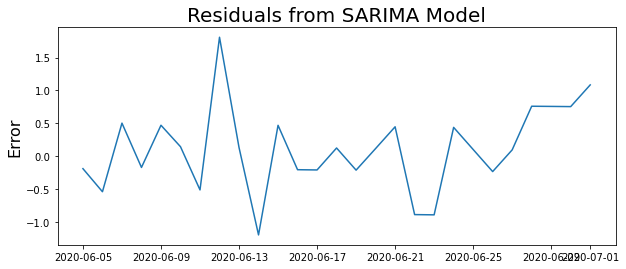

In [30]:
plt.figure(figsize=(10,4))
plt.plot(test.index, (pred_df.aqi - test.aqi), label='Train')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)